In [2]:
# -*- coding: utf-8 -*-
# dehaze algorithm
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
 
def zmMinFilterGray(src, r=7):
    '''最小值滤波，r是滤波器半径'''
    if r <= 0:
        return src
    h, w = src.shape[:2]
    I = src
    res = np.minimum(I  , I[[0]+range(h-1)  , :])
    res = np.minimum(res, I[range(1,h)+[h-1], :])
    I = res
    res = np.minimum(I  , I[:, [0]+range(w-1)])
    res = np.minimum(res, I[:, range(1,w)+[w-1]])
    return zmMinFilterGray(res, r-1)
 
def guidedfilter(I, p, r, eps):
    '''引导滤波，直接参考网上的matlab代码'''
    height, width = I.shape
    m_I = cv2.boxFilter(I, -1, (r,r))
    m_p = cv2.boxFilter(p, -1, (r,r))
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))
    cov_Ip = m_Ip-m_I*m_p
 
    m_II = cv2.boxFilter(I*I, -1, (r,r))
    var_I = m_II-m_I*m_I
 
    a = cov_Ip/(var_I+eps)
    b = m_p-a*m_I
 
    m_a = cv2.boxFilter(a, -1, (r,r))
    m_b = cv2.boxFilter(b, -1, (r,r))
    return m_a*I+m_b
 
def getV1(m, r, eps, w, maxV1):  #输入rgb图像，值范围[0,1]
    '''计算大气遮罩图像V1和光照值A, V1 = 1-t/A'''
    V1 = np.min(m,2)                                         #得到暗通道图像
    V1 = guidedfilter(V1, zmMinFilterGray(V1,7), r, eps)     #使用引导滤波优化
    bins = 2000
    ht = np.histogram(V1, bins)                              #计算大气光照A
    d = np.cumsum(ht[0])/float(V1.size)
    for lmax in range(bins-1, 0, -1):
        if d[lmax]<=0.999:
            break
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()
         
    V1 = np.minimum(V1*w, maxV1)                   #对值范围进行限制
     
    return V1,A
 
def deHaze(m, r=81, eps=0.001, w=1, maxV1=0.80, bGamma=False):
    Y = np.zeros(m.shape)
    V1,A = getV1(m, r, eps, w, maxV1)               #得到遮罩图像和大气光照
    for k in range(3):
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #颜色校正
    Y =  np.clip(Y, 0, 1)
    if bGamma:
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #gamma校正,默认不进行该操作
    return Y
 
# if __name__ == '__main__':
Filepath = './050724be2.jpg'
img = cv2.imread(Filepath)
plt.imshow(img.astype(np.uint8))

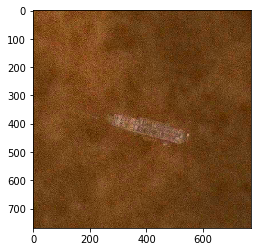

In [3]:
m = deHaze(img/255.0)*255
plt.imshow(m.astype(np.uint8))

In [4]:
import datetime
def rgbtohsi(rgb_lwpImg):
    rows,cols,_ = rgb_lwpImg.shape
    count=0.0
    rows=rows/10
    cols=cols/10
    for i in range(rows):
        for j in range(cols):
            I = (rgb_lwpImg[i, j, 0]/3.0+rgb_lwpImg[i, j,1]/3.0+rgb_lwpImg[i, j, 2]/3.0)
            if I >= 100:
                count = count+1
    return count/(rows*cols)
oldtime=datetime.datetime.now() 
Filepath = './0b0efcb5f.jpg'
img = cv2.imread(Filepath)
newtime=datetime.datetime.now()
print(newtime-oldtime)
print(rgbtohsi(img))

0:00:00.016595
0.333102493075


In [ ]:
# -*- coding: utf-8 -*-
#Line detection
import cv2
import numpy as np
import os
import pandas as pd
import datetime

ship_dir = '/datasets/ee285f-public/airbus_ship_detection/'
train_image_dir = r'/datasets/ee285f-public/airbus_ship_detection/train_v2/' 
file_list = os.listdir(train_image_dir)
print("start")
count=0
oldtime=datetime.datetime.now() 
for f in file_list:
    Filepath = os.path.join(train_image_dir,f)
    img = cv2.imread(Filepath)
    if rgbtohsi(img)>0.5:
        img= deHaze(img/255.0)*255
        img= img.astype(np.uint8)
    else:
        pass
    blur = cv2.medianBlur(img, 7)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 1, 180, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=1,minLineLength=5,maxLineGap=5) 
    if lines is not None:
        df=pd.DataFrame(data=[f],columns=['maybe'])
        df.to_csv('./maybe.csv', mode='a',index=False, header=False )
    else:
        df=pd.DataFrame(data=[f],columns=['background'])
        df.to_csv('./bg.csv', mode='a',index=False, header=False )
    count=count+1
    if(count==1000):
        newtime=datetime.datetime.now()
        print(newtime-oldtime)
print('finished')

start
0:06:44.900508


In [7]:
#check error rate
ship_dir = '/datasets/ee285f-public/airbus_ship_detection/'
train_image_dir = r'/datasets/ee285f-public/airbus_ship_detection/train_v2/' 
imgs = set()
csv_filename = os.path.join(ship_dir,
                             '/datasets/ee285f-public/airbus_ship_detection/train_ship_segmentations_v2.csv')
csv_data = pd.read_csv(csv_filename)
csv_data_true = csv_data.isnull()
for i in range(csv_data.shape[0]):
    if csv_data_true['EncodedPixels'][i]:
        imgs.add(csv_data['ImageId'].values[i])
bg_data =  pd.read_csv('./bg.csv',header=None)
count_err=0
for i in range(bg_data.shape[0]):
    if bg_data[0][i] not in(imgs):
        count_err=count_err+1
print(count_err*1.0/bg_data.shape[0])

0.0492189802535
